In [14]:
from __future__ import division, print_function

In [15]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

**Utils**

In [16]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [17]:
#style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
style = "clean.mplstyle"

In [19]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Solución exacta")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Datos de entrenamiento')
        if yh is not None:
            plt.scatter(x, yh, label="Predicción red neuronal", s=10, color='#377eb8')
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Iteración %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

**Main problem**

### **CNN**

In [20]:
def f_rhs(x):
   return -4*torch.sin(2 * x)

def exact_u(x):
    return torch.sin(2 * x)

def exact_u_singular(x):
  return x**0.7 * (x - torch.pi)

def f_singular_rhs(x):
  return -0.7 * 0.3 * (x**-1.3) * (x - torch.pi) + (0.7*x**-0.3) * (1) + (0.7 * x**-0.3)  

class CNNPDE(nn.Module):
    def __init__(self):
        super(CNNPDE, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool1d(x, x.size()[2])  
        x = x.permute(0, 2, 1)  
        output = self.fc(x)
        return output.squeeze(1)  

**Training data**

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([15, 1]) torch.Size([15, 1])


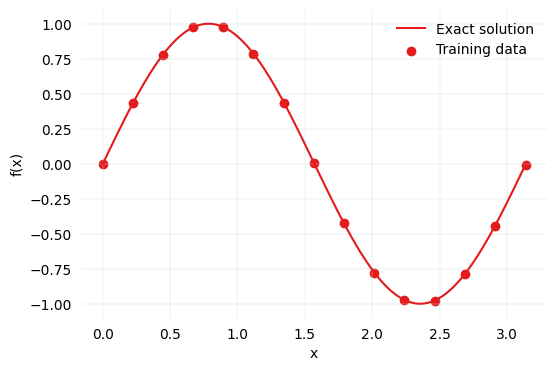

In [21]:
n_pts = 1000

x = np.array([np.pi/n_pts * i for i in range(n_pts)])
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = exact_u(x).view(-1, 1)
print(x.shape, y.shape)

num_samples = 15
indices = np.linspace(0, len(x)-1, num_samples, dtype=int)
x_data = x[indices]
y_data = y[indices]
print(x_data.shape, y_data.shape)

with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.plot(x, y, label="Exact solution")          
    plt.scatter(x_data, y_data, label='Training data')       
    plt.legend()
    
    plt.savefig('sen_func.png', dpi=300, bbox_inches='tight')

    plt.show()

In [9]:
torch.manual_seed(123)
model = CNNPDE()
model

CNNPDE(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

**Params**

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 6401


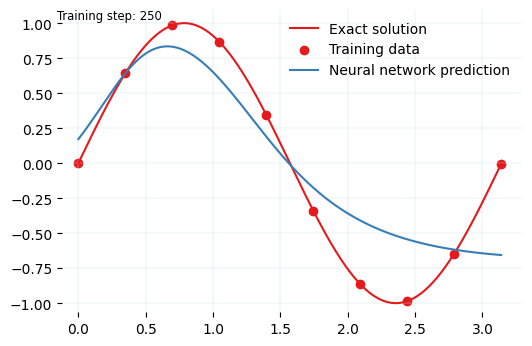

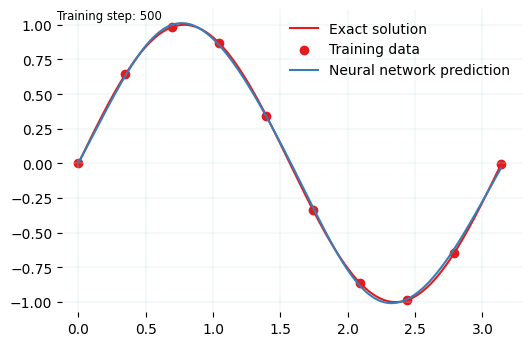

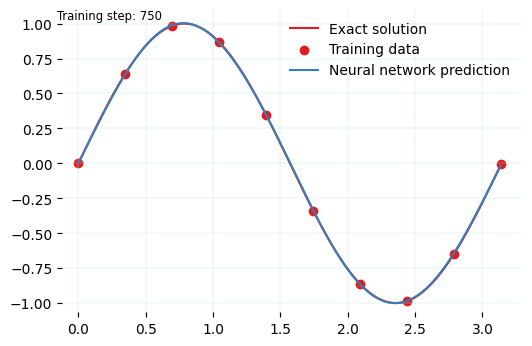

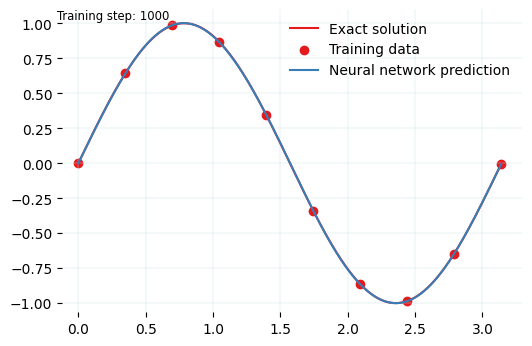

In [23]:
model = CNNPDE()
n_iterations = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(n_iterations):
  optimizer.zero_grad()
  yh = model(x_data)
  loss = torch.mean((yh-y_data)**2)
  loss.backward()
  optimizer.step()

  if (i+1) % 10 == 0:
    yh = model(x).detach()
    #plot_result(x, y, x_data, y_data, yh)
    style_plot(x, y, x_data, y_data, yh)
    file = "plots/nn_%.8i.png"%(i+1)    
    plt.savefig(file, bbox_inches=None, pad_inches=0.5, dpi=100, facecolor="white")
    files.append(file)

    if (i+1) % 250 == 0: plt.show()
    else: plt.close("all")
save_gif_PIL("nn_sen_data_gif.gif", files, fps=20, loop=0)

### **PICNN**

In [22]:
def compute_integral(y, x):    
    integral = torch.trapz(y, x, dim=0)
    return integral

def compute_errors(model, x, exact_u):
    exact_function = exact_u(x)
    predicted_function = model(x)

    error_between_functions = exact_function - predicted_function
    error_squared = error_between_functions**2
    L2_error = compute_integral(error_squared, x)

    # Calcular la norma L2 de la función exacta
    exact_squared = exact_function**2
    L2_exact = compute_integral(exact_squared, x)

    # Calcular el error relativo L2
    L2_relative_error = L2_error / L2_exact

    return L2_error, torch.sqrt(L2_relative_error)

Loss at iteration 50: 6.388524


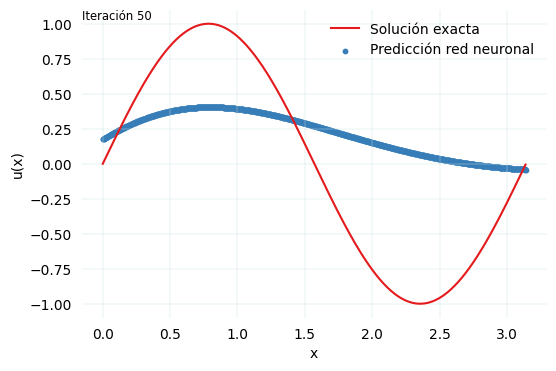

Loss at iteration 100: 1.837386


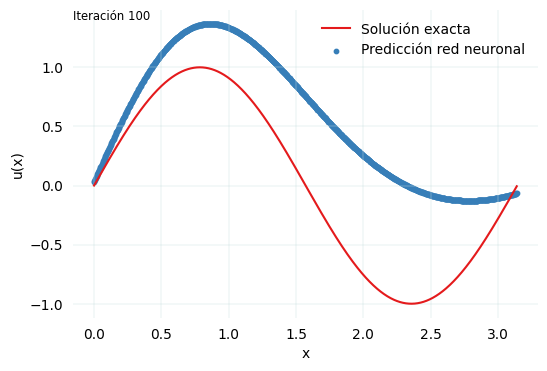

Loss at iteration 150: 0.227986


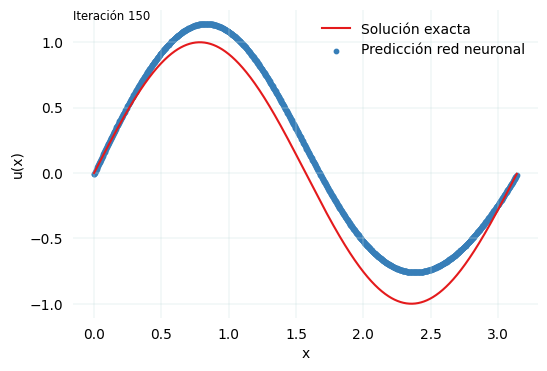

Loss at iteration 200: 0.064605


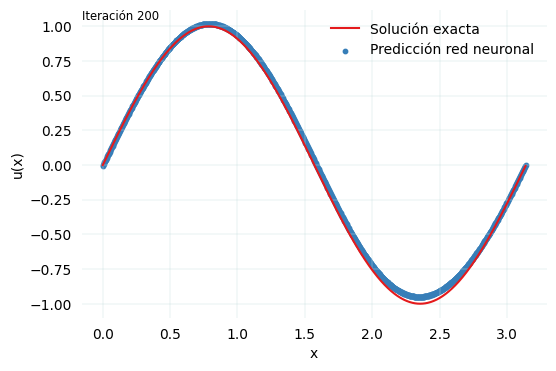

Loss at iteration 250: 0.043469


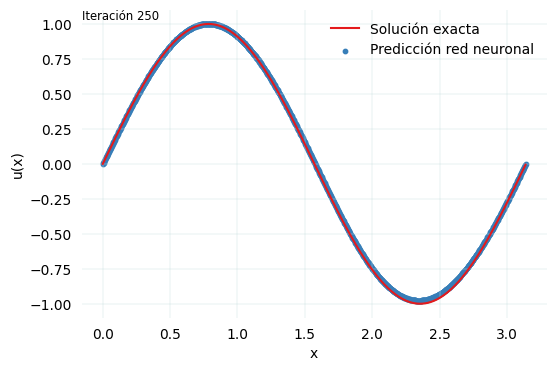

Loss at iteration 300: 0.033072


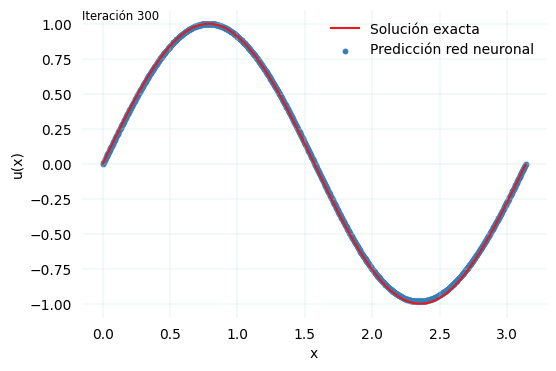

Loss at iteration 350: 0.023967


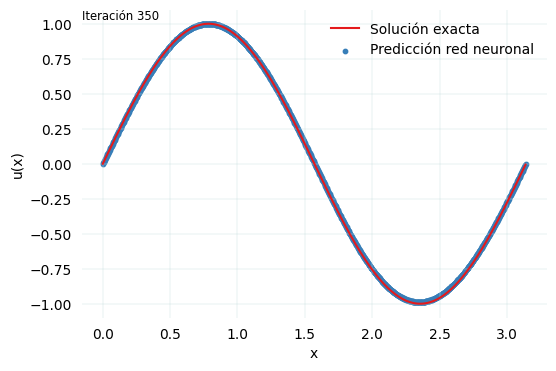

Loss at iteration 400: 0.017066


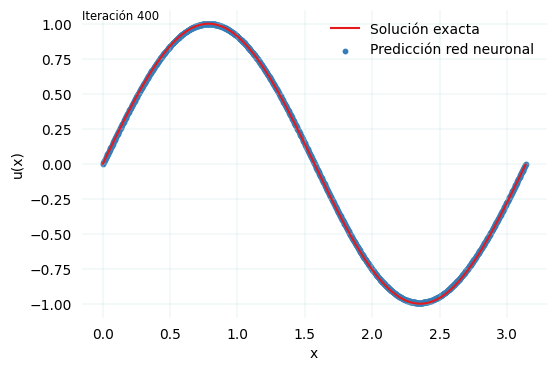

Loss at iteration 450: 0.012547


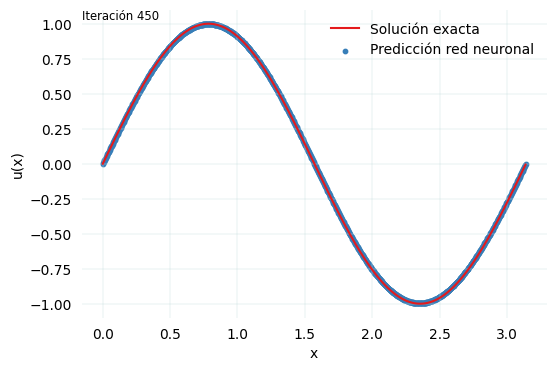

Loss at iteration 500: 0.009685


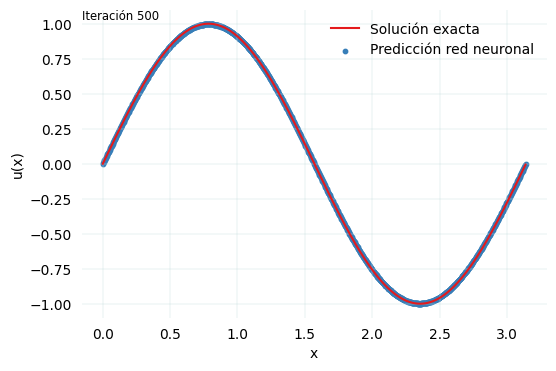

Loss at iteration 550: 0.007682


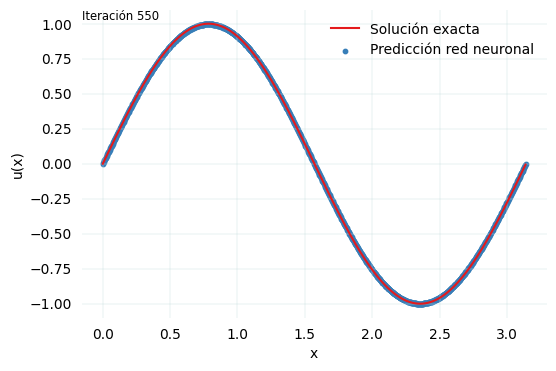

Loss at iteration 600: 0.006136


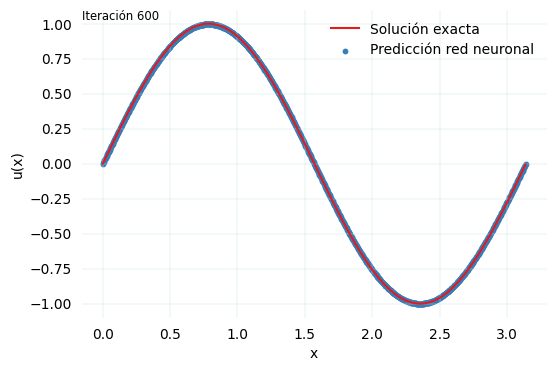

Loss at iteration 650: 0.004902


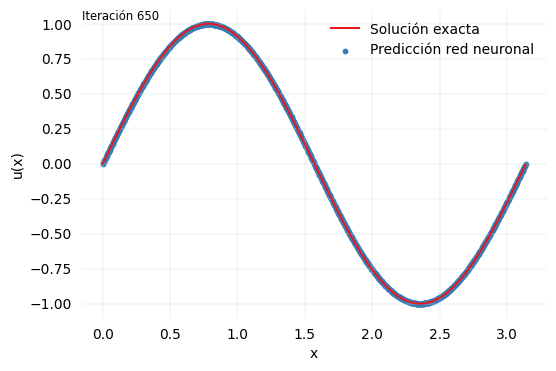

Loss at iteration 700: 0.003912


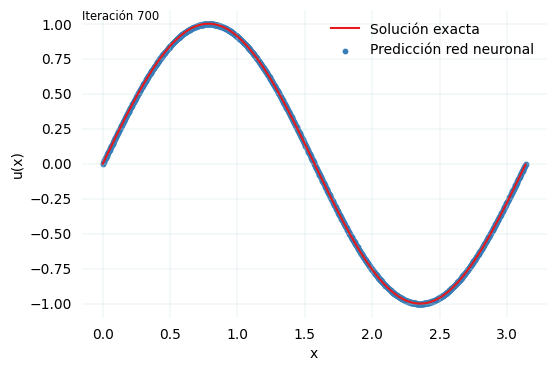

Loss at iteration 750: 0.003118


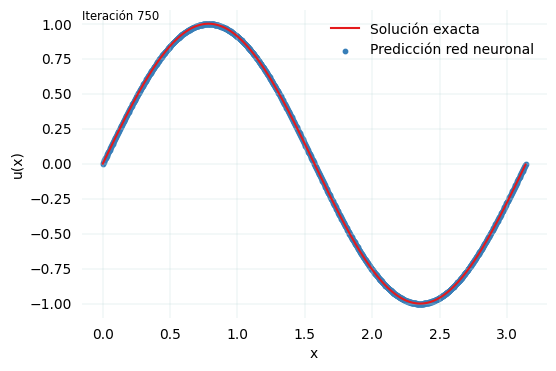

Loss at iteration 800: 0.002480


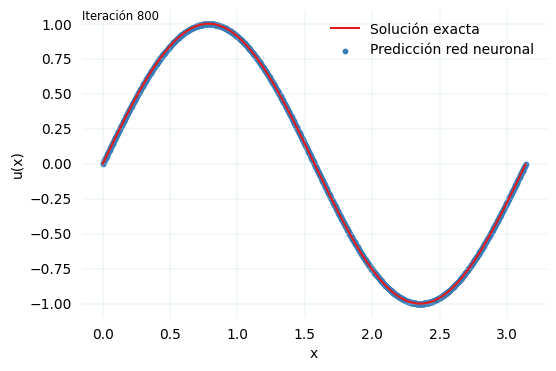

Loss at iteration 850: 0.001969


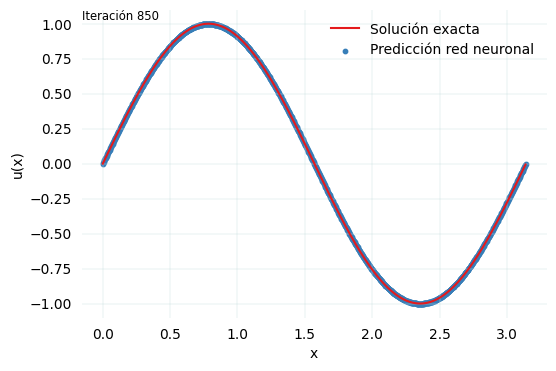

Loss at iteration 900: 0.001567


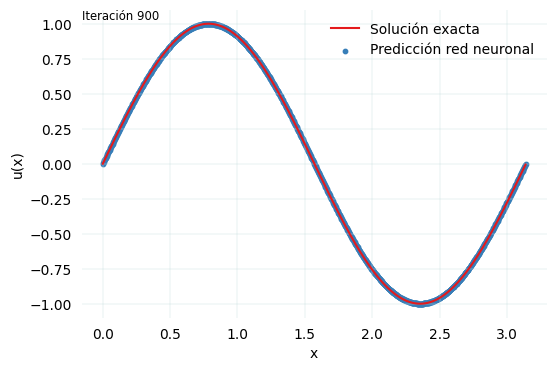

Loss at iteration 950: 0.001250


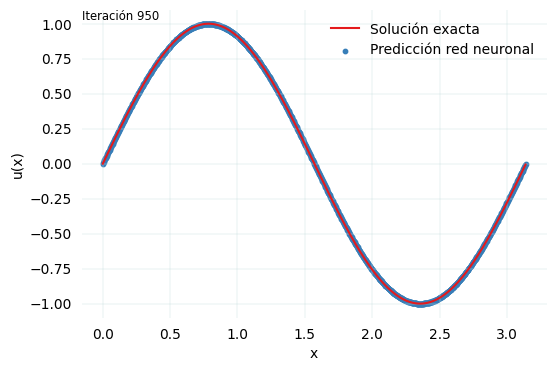

Loss at iteration 1000: 0.001000


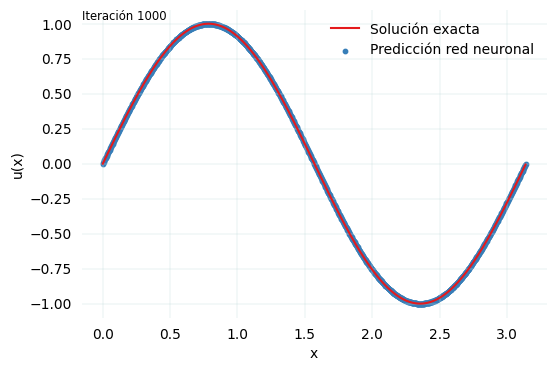

In [23]:
#x_physics = torch.FloatTensor(n_pts, 1).uniform_(0, np.pi).requires_grad_(True)
iterations = 1000

torch.manual_seed(123)
model = CNNPDE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
losses = []
output_errors = []
L2_errors = []
L2_relative_errors = []

for i in range(iterations):
    x_physics = torch.linspace(0, torch.pi, n_pts).requires_grad_(True)
    x_physics = x_physics.view(n_pts, 1)
    optimizer.zero_grad()

    # Physic loss
    yhp = model(x_physics)
    du = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    ddu = torch.autograd.grad(du, x_physics, torch.ones_like(du), create_graph=True)[0]
    error_PDE = torch.mean((ddu - f_rhs(x_physics))**2)
    bc = model(torch.tensor([np.pi]).unsqueeze(0))**2 + model(torch.tensor([0.]).unsqueeze(0))**2
    
    # Backpropagation
    loss = error_PDE + bc
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Compute L2 and relative L2 errors
    L2_error, L2_relative_error = compute_errors(model, x_physics, exact_u)
    L2_errors.append(L2_error.item())
    L2_relative_errors.append(L2_relative_error.item())

    if (i+1) % 50 == 0:
        print(f"Loss at iteration {i+1}: {loss.item():.6f}")

    if (i+1) % 10 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        #plot_result(x,y,x_data,y_data,yh,xp)
        style_plot(x, y, x_data=None, y_data=None, yh=yh)
        plt.xlabel('x')
        plt.ylabel('u(x)')

        file = "plots/pinn_%.8i.pdf"%(i+1)              
        plt.savefig(file, bbox_inches=None, pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 50 == 0: plt.show()
        else: plt.close("all")
#save_gif_PIL("cnn_sen_physics_gif.gif", files, fps=20, loop=0)

In [24]:
L2_relative_errors[-1]

0.0012677479535341263

**Loss and L2 Error**

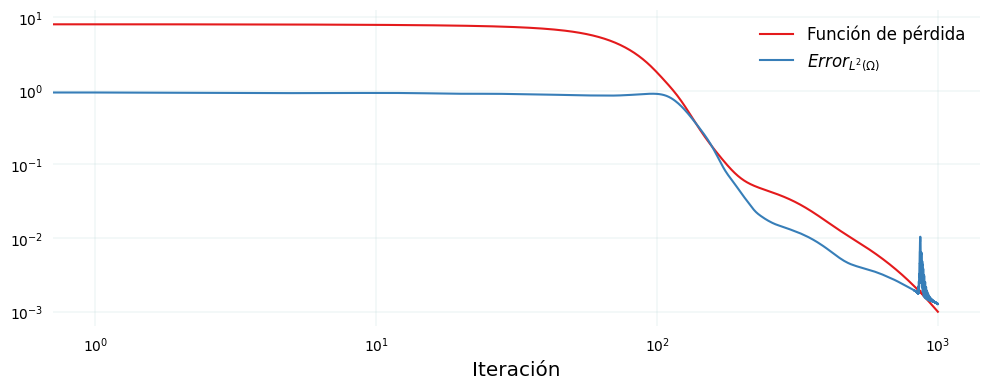

In [12]:
with plt.style.context(style):        
    fig, ax = plt.subplots(figsize=(10, 4))

    # Graficar la función de pérdida en escala semilog
    ax.loglog(losses, label="Función de pérdida")

    # Graficar el error L2 en escala semilog en la misma gráfica
    ax.loglog(L2_relative_errors, label="$Error_{L^{2}(\Omega)}$")

    # Configurar los títulos y etiquetas    
    ax.set_xlabel("Iteración", fontsize="x-large")  # Cambiar a "x-large"    
    ax.legend(fontsize="large")

    # Ajustar el layout y mostrar la figura
    plt.tight_layout()
    plt.savefig('cnn_combined_loglog_plot.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
losses[-1], L2_errors[-1]

(0.001000271295197308, 0.0015888705383986235)

##### **Error**

In [11]:
x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)

exact_function = exact_u(x_physics)
predicted_function = model(x_physics).detach()
error_between_arrays = exact_function - predicted_function

Mean Squared Error (MSE)

In [12]:
# Error relativo
output_error = torch.mean((error_between_arrays)**2)
output_error /= torch.mean(exact_function**2)
print(f"Output error: {output_error.item():.8f}")

Output error: 0.00000161


Max Error

In [13]:
max_error = torch.max(torch.abs(error_between_arrays))
max_error /= torch.max(torch.abs(exact_function))
print(f"Max error: {max_error.item():.8f}")

Max error: 0.00146205


Min Error

In [14]:
min_error = torch.min(torch.abs(error_between_arrays))
min_error /= torch.max(torch.abs(exact_function))
print(f"Min error: {min_error.item():.8f}")

Min error: 0.00000417


Avg Error

In [16]:
times_greater = 6401 / 361
print(times_greater)

17.73130193905817


In [15]:
avg_error = torch.mean(torch.abs(error_between_arrays))
avg_error /= torch.mean(torch.abs(exact_function))
print(f"Avg error: {avg_error.item():.8f}")

Avg error: 0.00132723


**Save PICNN model**

In [26]:
torch.save(model.state_dict(), "models/poisson1_picnn.pth")

In [27]:
model = CNNPDE()
model.load_state_dict(torch.load("models/poisson1_picnn.pth"))

<All keys matched successfully>

In [28]:
model.eval()

CNNPDE(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=64, out_features=1, bias=True)
)